In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
# from shapely.geometry import Point
# from geopandas import GeoDataFrame
import os
from os.path import join
import pandas as pd
import fiona
# from cartopy import crs as ccrs
# from urllib.request import urlopen
# from zipfile import ZipFile
# from io import BytesIO
# from pathlib import Path

sns.set(style='white')
cwd = os.getcwd()
data_path = join(cwd, '..', 'Data storage')
figure_path = join(cwd,'..', 'Figures')
file_date = '2018-03-06'

In [3]:
%load_ext watermark
%watermark -v -p pandas,geopandas,shapely

CPython 3.6.4
IPython 6.2.1

pandas 0.22.0
geopandas 0.3.0
shapely 1.6.4.post1


## Read NERC regions shapefile

In [149]:
path = os.path.join(data_path, 'nercregions', 'NERCregions.shp')
regions_nerc = gpd.read_file(path)
regions_nerc['nerc'] = regions_nerc['NERCregion']

In [150]:
regions_nerc

,OBJECTID,NERCregion,SHAPE_Leng,SHAPE_Area,geometry,nerc
0,1,FRCC,22.488030,11.459289,POLYGON ((-84.86300370899994 30.71266453000004...,FRCC
1,2,MRO,76.997961,130.425939,"POLYGON ((-94.8320392469999 49.33080593000005,...",MRO
2,3,NPCC,48.574281,32.754394,(POLYGON ((-72.5509712409999 40.96617993100006...,NPCC
3,4,RFC,99.332877,71.157869,(POLYGON ((-87.92640864299995 44.5391396020000...,RFC
4,5,SERC,128.958444,142.139208,POLYGON ((-80.20680177299994 36.54903791300006...,SERC
5,6,SPP,61.523164,56.496471,POLYGON ((-97.56098691099993 36.38533196100008...,SPP
6,7,TRE,44.145641,50.605118,POLYGON ((-104.4498774409999 32.00686615000006...,TRE
7,8,WECC,102.110211,323.227276,(POLYGON ((-122.6656125679999 48.3967777520000...,WECC


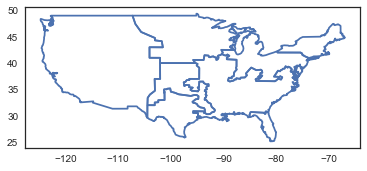

In [151]:
regions_nerc.boundary.plot()

## Read states shapefile

In [4]:
path = os.path.join(data_path, 'cb_2016_us_state_20m', 'cb_2016_us_state_20m.shp')
states = gpd.read_file(path)
states.crs

{'init': 'epsg:4269'}

In [6]:
drop_states = ['Alaska', 'Hawaii', 'Puerto Rico']
states = states.loc[~states['NAME'].isin(drop_states)]

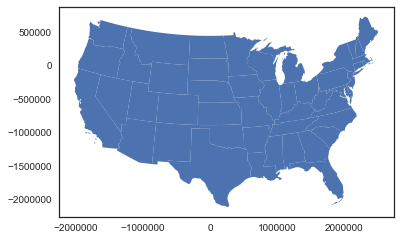

In [7]:
states.to_crs(epsg=2163).plot()

In [8]:
path = join(data_path, 'final NERC data',
            'Summary table {}.csv'.format(file_date))
index = pd.read_csv(path)
index

,nerc,2001,2017,Reduction,Percent Reduction,Annual Reduction
0,TRE,609.480997,445.396025,164.084972,0.269221,10.255311
1,WECC,520.628493,346.627554,174.000939,0.334213,10.875059
2,USA,629.016312,438.047363,190.968949,0.303599,11.935559
3,SERC,633.368212,426.814179,206.554033,0.326120,12.909627
4,RFC,676.181487,461.065520,215.115966,0.318133,13.444748
5,FRCC,648.223415,410.133060,238.090355,0.367297,14.880647
6,NPCC,414.395302,172.744904,241.650399,0.583140,15.103150
7,MRO,855.109267,541.516736,313.592531,0.366728,19.599533
8,SPP,853.801162,494.664676,359.136486,0.420632,22.446030


In [152]:
for nerc in regions_nerc['nerc'].unique():
    try:
        val_2017 = index.loc[index['nerc']==nerc, '2017'].values[0]
        val_2001 = index.loc[index['nerc']==nerc, '2001'].values[0]
        reduce = index.loc[index['nerc']==nerc, 'Percent Reduction'].values[0]
        regions_nerc.loc[regions_nerc['nerc']==nerc, 2017] = val_2017
        regions_nerc.loc[regions_nerc['nerc']==nerc, 2001] = val_2001
        
        regions_nerc.loc[regions_nerc['nerc']==nerc, 'reduction'] = '{:.0%}'.format(reduce)
        regions_nerc.loc[regions_nerc['nerc']==nerc, 'reduction value'] = reduce
    except:
        pass

### Transform projection to Albers equal area

In [154]:
regions_albers = regions_nerc.to_crs(epsg=2163)
states_albers = states.to_crs(epsg=2163)

### Plot data

In [16]:
# https://gist.github.com/springmeyer/871897
# Convert lon/lat into meters for use in the projected space

def conv_lon(x):
    newx = x * 20037508.34 / 180
    return newx

def conv_lat(y):
    newy = np.log(np.tan((90 + y) * np.pi / 360)) / (np.pi / 180)
    newy *= 20037508.34 / 180
    return newy

In [169]:
def plot_nerc_annual(regions_proj, states_proj, data_col, text_col,
                     cmap='cividis_r', vmin=None, vmax=None, title=None,
                     cbar_title=None, **kwargs):
    
    states_ec = kwargs.get('states_ec', '0.6')
    regions_ec = kwargs.get('regions_ec', '0.2')
    regions_lw = kwargs.get('regions_lw', 0.75)
    font_size = kwargs.get('font_size', 9)
    bbox_alpha = kwargs.get('bbox_alpha', 0.7)
    FRCC_x = kwargs.get('FRCC_x', 4.75)
    SERC_x = kwargs.get('SERC_x', 2)
    SERC_y = kwargs.get('SERC_y', -2)
    SPP_y = kwargs.get('SPP_y', 1.75)
    RFC_y = kwargs.get('RFC_y', -0.5)
    
    
    fig, ax = plt.subplots(figsize=(8,3.5))
    # set aspect to equal. This is done automatically
    # when using *geopandas* plot on it's own, but not when
    # working with pyplot directly.
    ax.set_aspect('equal')


    regions_proj.plot(ax=ax, column=data_col, cmap=cmap, legend=True,
                      vmin=vmin, vmax=vmax)
    states_proj.plot(ax=ax, color='none', edgecolor=states_ec)
    regions_proj.plot(ax=ax, color='none', edgecolor=regions_ec,
                     linewidth=regions_lw)
#     plt.text(x=1.1, y=1.01, s=cbar_title, transform=ax.transAxes,
#              ha='center', va='bottom', fontdict={'size':font_size})
    plt.title(title)

    for point, nerc in zip(regions_proj.centroid, regions_proj['nerc'].values):
        text = regions_proj.loc[regions_proj['nerc']==nerc, text_col].values[0]
#         text = '{}'.format(nerc, reduce)
        x = point.x
        y = point.y
        if nerc == 'FRCC':
            x = x + conv_lon(4.75)#-79
            y = y - conv_lat(1)#28
            rot = -67
            plt.text(x, y, text, ha='center', va='center',
                     fontdict={'size':font_size})

        elif nerc == 'NPCC':
            x = x - conv_lon(1.5)
            y = y + conv_lat(2.1)
            plt.text(x, y, text, ha='center', 
                     fontdict={'size':font_size})

        elif nerc == 'SERC':
            x = x + conv_lon(SERC_x)
            y = y + conv_lat(SERC_y)
            plt.text(x, y, text, ha='center', va='center',
                     bbox=dict(facecolor='white',
                                alpha=bbox_alpha,
                                boxstyle="square"),
                     fontdict={'size':font_size})
        elif nerc == 'RFC':
#             x = x + conv_lon(RFC_x)
            y = y + conv_lat(RFC_y)
            plt.text(x, y, text, ha='center', va='center',
                     bbox=dict(facecolor='white',
                                alpha=bbox_alpha,
                                boxstyle="square"),
                     fontdict={'size':font_size})
        
        elif nerc == 'SPP':
    #         x = x + 2
            y = y + conv_lat(SPP_y)
            plt.text(x, y, text, ha='center', va='center',
                     bbox=dict(facecolor='white',
                                alpha=bbox_alpha,
                                boxstyle="square"),
                     fontdict={'size':font_size})

        else:
            plt.text(x, y, text, ha='center', va='center',
                     bbox=dict(facecolor='white',
                                alpha=bbox_alpha,
                                boxstyle="square"),
                     fontdict={'size':font_size})

    sns.despine(left=True, bottom=True)
    ax.set_yticklabels(labels=[])
    ax.set_xticklabels(labels=[])
    
    cax = fig.get_axes()[-1]
    cax.set_title(cbar_title, fontdict={'size':font_size})

### Maps of 2001 and 2017 annual values

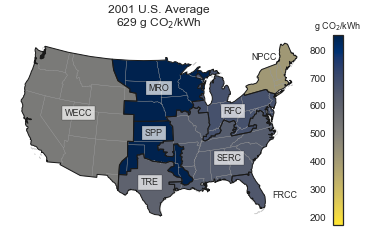

In [170]:
title = '2001 U.S. Average\n{} g CO$_2$/kWh'.format(usa_2001)
kwargs = dict(
    regions_lw = 1,
    regions_ec = '0.1',
    SERC_y = -1.5,
    SPP_y = 2.25
)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col=2001,
                 text_col='nerc', vmin=vmin, vmax=vmax, title=title,
                 cbar_title='g CO$_2$/kWh', **kwargs)

path = join(figure_path, 'NERC map_cividis_2001.png')
plt.savefig(path, bbox_inches='tight', dpi=350)

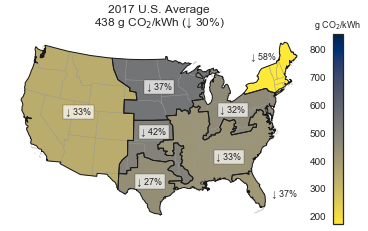

In [171]:
title = '2017 U.S. Average\n{} g CO$_2$/kWh (↓ 30%)'.format(usa_2017)
kwargs = dict(
    regions_lw = 1,
    regions_ec = '0.1',
    SERC_y = -1.5,
    SPP_y = 2.25
)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
regions_albers['arrow reduction'] = '↓ ' + regions_albers['reduction']
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col=2017,
                 text_col='arrow reduction', vmin=vmin, vmax=vmax, title=title,
                 cbar_title='g CO$_2$/kWh', **kwargs)
path = join(figure_path, 'NERC map_cividis_2017_change.png')
plt.savefig(path, bbox_inches='tight', dpi=350)